# Setup

There is a hidden initialization cell below. It should run automatically and print, but if it does not, please run it.

In [1]:
%matplotlib inline

print('Loading libraries... Please wait.')

from IPython.display import display, clear_output
import ipywidgets as widgets
import random
import sys
from collections import namedtuple, Counter
from sklearn.metrics import confusion_matrix, accuracy_score

from esper.prelude import *
from esper.widget import *
import esper.face_embeddings as face_embeddings


WIDGET_STYLE_ARGS = {'description_width': 'initial'}


LabelingState = namedtuple('LabelingState', ['faces', 'labels', 'attribute', 'options'])


def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')


def query_sample(qs, n):
    return qs.order_by('?')[:n]


def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and 
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] + 
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '', 
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }], 
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}


def simple_random_sampler(n):
    return set(face_embeddings.sample(n))


def get_labeling_state(n=100):
    faces = list(query_faces(simple_random_sampler(n)))
    attribute = attribute_to_label()
    if attribute == 'haircolor':
        options = {c.name: c for c in HairColorName.objects.all()}
    elif attribute == 'hairlength':
        options = {l.name: l for l in HairLengthName.objects.all()}
    elif attribute == 'clothing':
        options = {c.name: c for c in ClothingName.objects.all()}
    else:
        raise NotImplementedError()
    return LabelingState(faces=faces, labels={}, attribute=attribute,
                         options=options)


# def get_searchable_dropdown(name, options):
#     dropdown = widgets.Dropdown(
#         options=options,
#         value=options[0],
#         description='{}:'.format(name),
#         disabled=False
#     )
#     text = widgets.Text(
#         value='',
#         placeholder='search...',
#         continuous_update=True,
#         disabled=False
#     )
#     def on_update(b):
#         search_value = text.value.strip().lower()
#         for opt in options:
#             if search_value in opt:
#                 dropdown.value = opt
#                 break
#         else:
#             dropdown.value = options[0]
#     text.observe(on_update, names='value')
#     return text, dropdown


def save_attribute_labels(labeling_state):
    assert len(labeling_state.faces) == len(labeling_state.labels), 'Not all faces labeled'
    handlabeler_name = HANDLABELER_FORMAT.format(labeling_state.attribute)
    labeler = Labeler.objects.get(name=handlabeler_name)
    if labeling_state.attribute == 'haircolor':
        for face_id, label in labeling_state.labels.items():
            hc, created = HairColor.objects.get_or_create(
                face_id=face_id, labeler=labeler, 
                defaults={'color': labeling_state.options[label]})
            if not created:
                print('{} was already labeled: updated it'.format(face_id))
                hc.color = labeling_state.options[label]
            hc.save()
            
    elif labeling_state.attribute == 'hairlength':
        for face_id, label in labeling_state.labels.items():
            hl, created = HairLength.objects.get_or_create(
                face_id=face_id, labeler=labeler, 
                defaults={'length': labeling_state.options[label]})
            if not created:
                print('{} was already labeled: updated it'.format(face_id))
                hl.clothing = labeling_state.options[label]
            hl.save()
    
    elif labeling_state.attribute == 'clothing':
        for face_id, label in labeling_state.labels.items():
            cl, created = Clothing.objects.get_or_create(
                face_id=face_id, labeler=labeler, 
                defaults={'clothing': labeling_state.options[label]})
            if not created:
                print('{} was already labeled: updated it'.format(face_id))
                cl.clothing = labeling_state.options[label]
            cl.save()
    else:
        raise NotImplementedError()
    print('Saved {} {} labels (labeler_name={})'.format(
        len(labeling_state.labels), labeling_state.attribute, labeler.name))


def plot_label_distribution(labeling_state):
    options = sorted(list(labeling_state.options))
    ind = np.arange(len(options))
    counts = Counter(labeling_state.labels.values())
    plt.clf()
    plt.figure(figsize=(7, 1))
    plt.bar(ind, [counts[o] for o in options], align='center', alpha=0.5)
    plt.xticks(ind, options)
    plt.ylabel('Count')
    plt.title('Current labels')
    plt.show()


def label_face_attributes(labeling_state, order_by='random'):
    if len(labeling_state.labels) > 0:
        plot_label_distribution(labeling_state)
    unlabeled_faces = [f for f in labeling_state.faces if f['id'] not in labeling_state.labels]
    if len(unlabeled_faces) == 0:
        print('No unlabeled faces. You are ready to save the labels.')
        save_attribute_labels(labeling_state)
        return
    else:
        print('{} faces need to be labeled'.format(len(unlabeled_faces)))
    
    if order_by == 'attribute':
        unlabeled_face_ids = [f['id'] for f in unlabeled_faces]
        if labeling_state.attribute == 'haircolor':
            order = {
                x['face__id'] : x['color__id']
                for x in HairColor.objects.filter(
                    face__id__in=unlabeled_face_ids
                ).values('face__id', 'color__id')
            }

        elif labeling_state.attribute == 'hairlength':
            order = {
                x['face__id'] : x['length__id']
                for x in HairLength.objects.filter(
                    face__id__in=unlabeled_face_ids
                ).values('face__id', 'length__id')
            }
            
        elif labeling_state.attribute == 'clothing':
            order = {
                x['face__id'] : x['clothing__id']
                for x in Clothing.objects.filter(
                    face__id__in=unlabeled_face_ids
                ).values('face__id', 'clothing__id')
            }
        else:
            raise NotImplementedError()
        unlabeled_faces.sort(key=lambda x: order.get(x['id'], 0))
    
    elif order_by == 'random':
        random.shuffle(unlabeled_faces)
    
    else:
        print('Unknown sort order: using random instead', file=sys.stderr)
    
    label_toggle = widgets.ToggleButtons(
        options=sorted(labeling_state.options.keys()),
        description='{}:'.format(labeling_state.attribute),
        disabled=False,
        button_style=''
    )
    
    selection_widget = esper_widget(
        query_faces_result(unlabeled_faces), 
        disable_playback=True, jupyter_keybindings=True,
        crop_bboxes=labeling_state.attribute != 'clothing', results_per_page=faces_per_page())
    
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Update labels',
        disabled=False,
        button_style='danger'
    )
    def on_submit(b):
        selected_ids = [unlabeled_faces[i]['id'] for i in selection_widget.selected]
        ignored_ids = [unlabeled_faces[i]['id'] for i in selection_widget.ignored]
        selected_label = label_toggle.value
        clear_output()
        for i in selected_ids:
            labeling_state.labels[i] = selected_label
        for i in ignored_ids:
            labeling_state.labels[i] = 'unknown'
        label_face_attributes(labeling_state, order_by)
    submit_button.on_click(on_submit)
    
    refresh_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Refresh (w/o saving)',
        disabled=False,
        button_style=''
    )
    def on_refresh(b):
        clear_output()
        label_face_attributes(labeling_state, order_by)
    refresh_button.on_click(on_refresh)
    
    display(widgets.HBox([submit_button, refresh_button]))
    display(label_toggle)
    display(selection_widget)
    
    
def print_attribute_validation_stats(attribute, normalize=False, dark_light_hair=False):
    handlabeler_name = HANDLABELER_FORMAT.format(attribute)
    labeler = Labeler.objects.get(name=handlabeler_name)
    
    y_pred = []
    y_truth = []
    if attribute == 'haircolor':
        attribute_id_dict = {
            c.name: c.id for c in 
            HairColorName.objects.all().exclude(name='unknown')
        }
        hand_attributes = {
            x['face__id']: x['color__id']
            for x in HairColor.objects.filter(
                labeler=labeler
            ).exclude(color__name='unknown').values('face__id', 'color__id')
        }
        for x in HairColor.objects.filter(
            face__id__in=list(hand_attributes.keys()), 
            labeler__name='haotian-hairstyle'
        ).values('face__id', 'color__id'):
            y_pred.append(x['color__id'])
            y_truth.append(hand_attributes[x['face__id']])
            
        if dark_light_hair:
            dark_set = {attribute_id_dict[x] for x in ['black', 'brown', 'gray']}
            def to_dark_light(i):
                if i == attribute_id_dict['white']:
                    return 2
                return 0 if i in dark_set else 1 
            y_pred = [to_dark_light(y) for y in y_pred]
            y_truth = [to_dark_light(y) for y in y_truth]
            attribute_id_dict = {'dark': 0, 'blonde': 1, 'white': 2}

    elif attribute == 'hairlength':
        attribute_id_dict = {
            l.name: l.id for l in 
            HairLengthName.objects.all().exclude(name='unknown')
        }
        hand_attributes = {
            x['face__id']: x['length__id']
            for x in HairLength.objects.filter(
                labeler=labeler
            ).exclude(length__name='unknown').values('face__id', 'length__id')
        }
        for x in HairLength.objects.filter(
            face__id__in=list(hand_attributes.keys()), 
            labeler__name='haotian-hairstyle'
        ).values('face__id', 'length__id'):
            y_pred.append(x['length__id'])
            y_truth.append(hand_attributes[x['face__id']])
    
    elif attribute == 'clothing':
        attribute_id_dict = {
            c.name: c.id for c in 
            ClothingName.objects.all().exclude(name='unknown')
        }
        hand_attributes = {
            x['face__id']: x['clothing__id']
            for x in Clothing.objects.filter(
                labeler=labeler
            ).exclude(clothing__name='unknown').values('face__id', 'clothing__id')
        }
        for x in Clothing.objects.filter(
            face__id__in=list(hand_attributes.keys()), 
            labeler__name='haotian-clothing'
        ).values('face__id', 'clothing__id'):
            y_pred.append(x['clothing__id'])
            y_truth.append(hand_attributes[x['face__id']])
    else:
        raise NotImplementedError()
    
    classes = sorted(list(attribute_id_dict.keys()))
    inv_attribute_id_dict = {b: classes.index(a) for a, b in attribute_id_dict.items()}
    y_pred = [inv_attribute_id_dict[y] for y in y_pred]
    y_truth = [inv_attribute_id_dict[y] for y in y_truth]
    cm = confusion_matrix(y_truth, y_pred, labels=list(range(len(classes))))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print('{} faces have been hand-labeled with {}'.format(len(hand_attributes), attribute))
    print('Overall accuracy: {:0.2f}'.format(
          accuracy_score(y_truth, y_pred)))
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('{} confusion matrix'.format(attribute))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Hand label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
        
    
DEFAULT_FACES_PER_PAGE = 50
_faces_per_page_slider = widgets.IntSlider(
    value=DEFAULT_FACES_PER_PAGE,
    style=WIDGET_STYLE_ARGS,
    min=25,
    max=100,
    step=1,
    description='Faces per widget page:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def faces_per_page():
    try:
        return _faces_per_page_slider.value
    except:
        return DEFAULT_FACES_PER_PAGE

_attribute_buttons = widgets.RadioButtons(
    style=WIDGET_STYLE_ARGS,
    options=['haircolor', 'hairlength', 'clothing'],
    value='haircolor',
    description='Attribute to label:',
    disabled=False
)
    
print('Done!')

display(_faces_per_page_slider)
display(_attribute_buttons)
def attribute_to_label():
    return _attribute_buttons.value

HANDLABELER_FORMAT = 'handlabeled-{}-validation'
print('New labels will be saved with labeler:', HANDLABELER_FORMAT.format('<attribute>'))

Loading libraries... Please wait.
Done!


IntSlider(value=50, continuous_update=False, description='Faces per widget page:', min=25, style=SliderStyle(d…

RadioButtons(description='Attribute to label:', options=('haircolor', 'hairlength', 'clothing'), style=Descrip…

New labels will be saved with labeler: handlabeled-<attribute>-validation


# Labeling

`get_labeling_state()` will sample faces from the dataset and `label_face_attributes()` will update the state with labels.

<b>Keys:</b>
 - To label a face with an attribute, press '['. To label all faces on a page, press '{' (i.e., shift + '[').
 - To label a face as unknown ']'.
 - To expand an image, press '=', and press again to shrink it.

In [ ]:
label_face_attributes(get_labeling_state(n=faces_per_page()), order_by='attribute')

You can view the current validation statistics by calling `print_attribute_validation_stats()`.

1310 faces have been hand-labeled with haircolor
Overall accuracy: 0.90


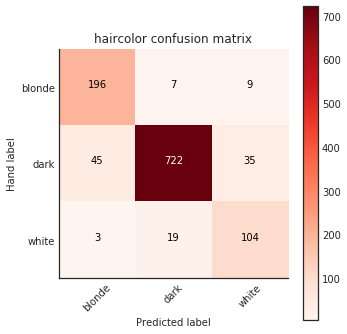

1310 faces have been hand-labeled with haircolor
Overall accuracy: 0.90


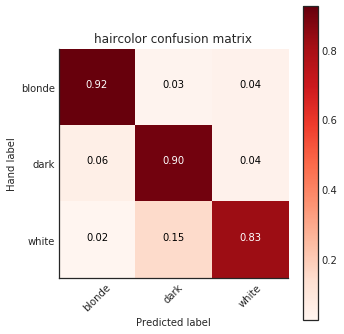


710 faces have been hand-labeled with hairlength
Overall accuracy: 0.85


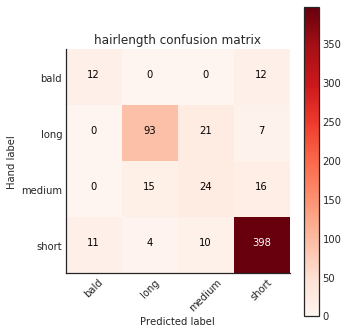

710 faces have been hand-labeled with hairlength
Overall accuracy: 0.85


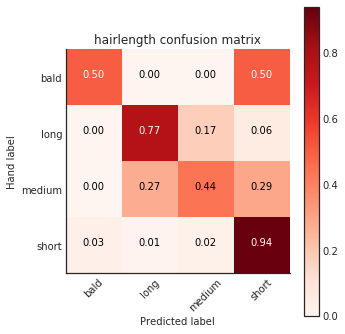


44 faces have been hand-labeled with clothing
Overall accuracy: 0.67


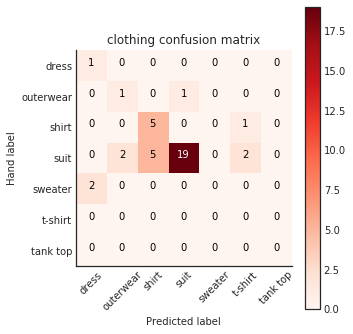

In [2]:
print_attribute_validation_stats('haircolor', normalize=False, dark_light_hair=True)
print_attribute_validation_stats('haircolor', normalize=True, dark_light_hair=True)
print()
print_attribute_validation_stats('hairlength', normalize=False)
print_attribute_validation_stats('hairlength', normalize=True)
print()
print_attribute_validation_stats('clothing', normalize=False)